In [ ]:
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import cv2
import math
import tensorflow
import os

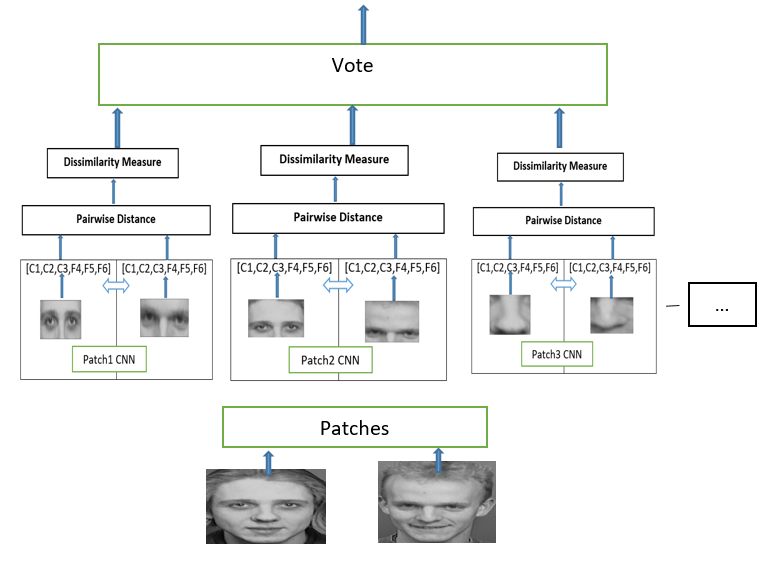

In [ ]:
class ConfigClass():
    #connect drive first
    train_dirEyes = '/content/drive/MyDrive/data/facesTrimmed/TrainingEyes'
    train_dirEyesForehead = '/content/drive/MyDrive/data/facesTrimmed/TrainingEyeForehead'
    train_dirEyesNose = '/content/drive/MyDrive/data/facesTrimmed/TrainingEyesNose'
    train_dirNose = '/content/drive/MyDrive/data/facesTrimmed/TrainingNose'
    train_Jaw = '/content/drive/MyDrive/data/facesTrimmed/TrainingJaw'
    train_dirEyesToChin = '/content/drive/MyDrive/data/facesTrimmed/TrainingEyeToChin'
    train_dirNoseToChin = '/content/drive/MyDrive/data/facesTrimmed/TrainingNoseMouth'
    train_dirLeftHalf = '/content/drive/MyDrive/data/facesTrimmed/TrainingLeftHalf'
    train_dirRightHalf = '/content/drive/MyDrive/data/facesTrimmed/TrainingRightHalf'

    test_dir = '/content/drive/My Drive/data/facesTrimmed/Testing/'   
    #train_dir = './Siamese Networks/data/faces/training/'
    #test_dir = './Siamese Networks/data/faces/testing/'
    train_batch_size = 74 #max = 740
    train_num_epochs = 100

In [ ]:
class SiameseDataset(Dataset):
    #constructor
    def __init__(self, image_folder, transform = None, invert = False): 
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index): #randomly returns a pair of images (as 100*100 tensors) and label, true if they are not of the same person, false if they are
        sample_1 = random.choice(self.image_folder.imgs) #randomly get some folder eg s1
        same_class = random.randint(0, 1)#random true or false
        
        if same_class:#1
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break #when sample2 is the same folder eg s1
        else:#0
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break #when s2 is another folder other than s1
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32)) 
        #returns 2 images and a label, true if they arent from the same folder(person) false if they are.
    def __len__(self):
        return len(self.image_folder.imgs)

In [ ]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()  

In [ ]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1) #Pads the input tensor using the reflection of the input boundary.
        '''
        in_channels (int) – Number of channels in the input image
        out_channels (int) – Number of channels produced by the convolution
        kernel_size (int or tuple) – Size of the convolving kernel
        stride (int or tuple, optional) – Stride of the convolution. Default: 1
        '''
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(5, 14, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(14, 60, kernel_size=3, stride=2) 
        self.relu = nn.ReLU(inplace=True)
        '''
        Normalization Layers
        Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, 
        as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, 
        and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, 
        and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture 
        and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful 
        about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout
        '''
        self.batch_norm1 = nn.BatchNorm2d(5) # 4 = number of features
        self.batch_norm2 = nn.BatchNorm2d(14)
        self.batch_norm3 = nn.BatchNorm2d(60) 
        '''
        Linear Layers
        Applies a linear transformation to the incoming data
        in_features – size of each input sample
        out_features – size of each output sample
        bias – If set to False, the layer will not learn an additive bias. Default: True
        '''
        self.fc1 = nn.Linear(60*13*13, 3200) #8 features, 100*100 is the size of the images
        self.fc2 = nn.Linear(3200, 1600)
        self.fc3 = nn.Linear(1600, 40)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x)))) #padding, conv, relu, normalise (4 outputs)
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x)))) #conv, relu, normalise (8 outputs)       
        x = self.batch_norm3(self.relu(self.conv3(self.reflection_pad(x)))) #conv, relu, normalise (8 outputs)  
        x = x.view(x.size()[0], -1) # a new pointer to x that allows us to do fast and memory efficient reshaping, slicing and element-wise operations.
        x = self.relu(self.fc1(x)) #linear transform (8 * 100 * 100) inputs , relu (500 outputs)
        x = self.relu(self.fc2(x)) #linear transform (500) inputs, relu (500 outputs)       
        x = self.fc3(x) #linear transform (500) inputs, relu (5 outputs)
        
        return x #5 output features
        
    def forward(self, input1, input2): #Forward through the siamese architecture
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2 #returns 5 output features for each image

In [ ]:
class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True) #Computes the batchwise pairwise distance between vectors v_1v1​, v_2v2​ using the p-norm
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)) #Pair-wise ranking loss
        
        return contrastive_loss #returns the loss

In [ ]:
def trainEyesModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirEyes) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  eyesModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(eyesModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = eyesModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return eyesModel


In [ ]:
def trainEyesForeheadModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirEyesForehead) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  eyesForeheadModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(eyesForeheadModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = eyesForeheadModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return eyesForeheadModel


In [ ]:
def trainNoseModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirNose) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  noseModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(noseModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = noseModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return noseModel

In [ ]:
def trainEyesNoseModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirEyesNose) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  eyesNoseModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(eyesNoseModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = eyesNoseModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return eyesNoseModel

In [ ]:
def trainJawModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_Jaw) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  jawModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(jawModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = jawModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return jawModel

In [ ]:
def trainEyesToChinModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirEyesToChin) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  eyesToChinModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(eyesToChinModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = eyesToChinModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return eyesToChinModel

In [ ]:
def trainNoseToChinModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirNoseToChin) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  noseToChinModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(noseToChinModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = noseToChinModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return noseToChinModel

In [ ]:
def trainLeftHalfModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirLeftHalf) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  leftHalfModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(leftHalfModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = leftHalfModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return leftHalfModel

In [ ]:
def trainRightHalfModel():
  image_folder = dataset.ImageFolder(root=ConfigClass.train_dirRightHalf) #Training dataset
  siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
  dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
  data_iter = iter(dataloader)
  vis_batch = next(data_iter)
  merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
  imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
  vis_batch[2].numpy() #8 labels

  rightHalfModel = SiameseNetwork().cuda()
  criterion = ConstrastiveLoss() #used to calculate how wrong the model is
  optimizer = optim.Adam(rightHalfModel.parameters(), lr=0.0005) 

  counter = []
  loss_history = []
  iteration = 0
  for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = rightHalfModel(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)          
  show_plot(counter, loss_history)
  return rightHalfModel

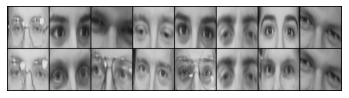

Epoch: 0 	 Loss: 1.7347651720046997
Epoch: 1 	 Loss: 0.6676729917526245
Epoch: 2 	 Loss: 1.3211095333099365
Epoch: 3 	 Loss: 0.5319472551345825
Epoch: 4 	 Loss: 0.3450988531112671
Epoch: 5 	 Loss: 0.44139474630355835
Epoch: 6 	 Loss: 0.3054782450199127
Epoch: 7 	 Loss: 0.2732469141483307
Epoch: 8 	 Loss: 0.18430325388908386
Epoch: 9 	 Loss: 0.20520716905593872
Epoch: 10 	 Loss: 0.238898366689682
Epoch: 11 	 Loss: 0.18829567730426788
Epoch: 12 	 Loss: 0.23742033541202545
Epoch: 13 	 Loss: 0.20388098061084747
Epoch: 14 	 Loss: 0.1912207007408142
Epoch: 15 	 Loss: 0.10760542750358582
Epoch: 16 	 Loss: 0.19286131858825684
Epoch: 17 	 Loss: 0.17697873711585999
Epoch: 18 	 Loss: 0.13090631365776062
Epoch: 19 	 Loss: 0.1298115998506546
Epoch: 20 	 Loss: 0.10657361894845963
Epoch: 21 	 Loss: 0.09474243223667145
Epoch: 22 	 Loss: 0.06857575476169586
Epoch: 23 	 Loss: 0.09964902698993683
Epoch: 24 	 Loss: 0.049958717077970505
Epoch: 25 	 Loss: 0.05509822070598602
Epoch: 26 	 Loss: 0.076031967997

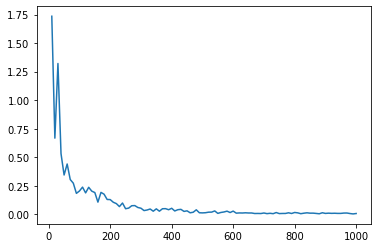

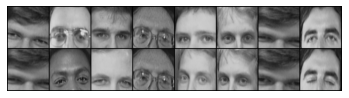

Epoch: 0 	 Loss: 1.6363531351089478
Epoch: 1 	 Loss: 0.3472940921783447
Epoch: 2 	 Loss: 0.5476248860359192
Epoch: 3 	 Loss: 0.32564207911491394
Epoch: 4 	 Loss: 0.3355189263820648
Epoch: 5 	 Loss: 0.234484001994133
Epoch: 6 	 Loss: 0.20368114113807678
Epoch: 7 	 Loss: 0.1558622270822525
Epoch: 8 	 Loss: 0.160929873585701
Epoch: 9 	 Loss: 0.17213726043701172
Epoch: 10 	 Loss: 0.156425341963768
Epoch: 11 	 Loss: 0.14138227701187134
Epoch: 12 	 Loss: 0.19920393824577332
Epoch: 13 	 Loss: 0.12326112389564514
Epoch: 14 	 Loss: 0.054199911653995514
Epoch: 15 	 Loss: 0.09022529423236847
Epoch: 16 	 Loss: 0.11791162937879562
Epoch: 17 	 Loss: 0.05950159579515457
Epoch: 18 	 Loss: 0.058338526636362076
Epoch: 19 	 Loss: 0.07217598706483841
Epoch: 20 	 Loss: 0.11629429459571838
Epoch: 21 	 Loss: 0.06574801355600357
Epoch: 22 	 Loss: 0.08378370106220245
Epoch: 23 	 Loss: 0.04805067181587219
Epoch: 24 	 Loss: 0.02386750653386116
Epoch: 25 	 Loss: 0.04218314215540886
Epoch: 26 	 Loss: 0.04237806051

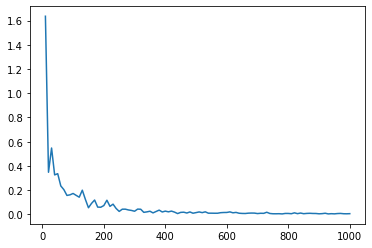

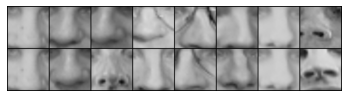

Epoch: 0 	 Loss: 0.9596503973007202
Epoch: 1 	 Loss: 0.8491203188896179
Epoch: 2 	 Loss: 0.9810605049133301
Epoch: 3 	 Loss: 0.7496094703674316
Epoch: 4 	 Loss: 0.47144073247909546
Epoch: 5 	 Loss: 0.3419906198978424
Epoch: 6 	 Loss: 0.3594576120376587
Epoch: 7 	 Loss: 0.4714187681674957
Epoch: 8 	 Loss: 0.2906598150730133
Epoch: 9 	 Loss: 0.2798243761062622
Epoch: 10 	 Loss: 0.14266760647296906
Epoch: 11 	 Loss: 0.1425510197877884
Epoch: 12 	 Loss: 0.1741108000278473
Epoch: 13 	 Loss: 0.2559443712234497
Epoch: 14 	 Loss: 0.11767727881669998
Epoch: 15 	 Loss: 0.1561036854982376
Epoch: 16 	 Loss: 0.11431815475225449
Epoch: 17 	 Loss: 0.22992557287216187
Epoch: 18 	 Loss: 0.18727536499500275
Epoch: 19 	 Loss: 0.12630197405815125
Epoch: 20 	 Loss: 0.10554283112287521
Epoch: 21 	 Loss: 0.09484107792377472
Epoch: 22 	 Loss: 0.1111564114689827
Epoch: 23 	 Loss: 0.09308483451604843
Epoch: 24 	 Loss: 0.0713777095079422
Epoch: 25 	 Loss: 0.10324636101722717
Epoch: 26 	 Loss: 0.08580125868320465

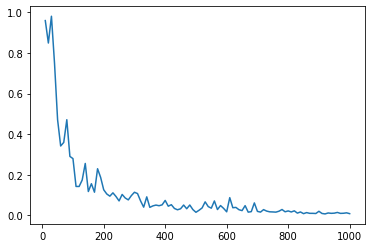

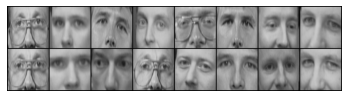

Epoch: 0 	 Loss: 2.5450618267059326
Epoch: 1 	 Loss: 0.7789624333381653
Epoch: 2 	 Loss: 0.6953685879707336
Epoch: 3 	 Loss: 0.5042084455490112
Epoch: 4 	 Loss: 0.35231515765190125
Epoch: 5 	 Loss: 0.34455177187919617
Epoch: 6 	 Loss: 0.25386080145835876
Epoch: 7 	 Loss: 0.2818787395954132
Epoch: 8 	 Loss: 0.2305833101272583
Epoch: 9 	 Loss: 0.13565979897975922
Epoch: 10 	 Loss: 0.21819563210010529
Epoch: 11 	 Loss: 0.2212739735841751
Epoch: 12 	 Loss: 0.11345373839139938
Epoch: 13 	 Loss: 0.1554395705461502
Epoch: 14 	 Loss: 0.12885530292987823
Epoch: 15 	 Loss: 0.08039668202400208
Epoch: 16 	 Loss: 0.10484995692968369
Epoch: 17 	 Loss: 0.12984773516654968
Epoch: 18 	 Loss: 0.07500530034303665
Epoch: 19 	 Loss: 0.0499042272567749
Epoch: 20 	 Loss: 0.08739741146564484
Epoch: 21 	 Loss: 0.04170702025294304
Epoch: 22 	 Loss: 0.06293240189552307
Epoch: 23 	 Loss: 0.049153804779052734
Epoch: 24 	 Loss: 0.03686569258570671
Epoch: 25 	 Loss: 0.04385561868548393
Epoch: 26 	 Loss: 0.0676408037

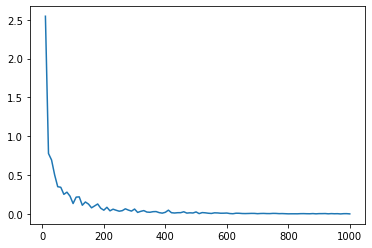

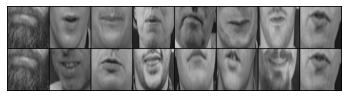

Epoch: 0 	 Loss: 4.225007057189941
Epoch: 1 	 Loss: 0.6823043823242188
Epoch: 2 	 Loss: 0.8427554965019226
Epoch: 3 	 Loss: 0.3796888589859009
Epoch: 4 	 Loss: 0.469093918800354
Epoch: 5 	 Loss: 0.4094989597797394
Epoch: 6 	 Loss: 0.34549757838249207
Epoch: 7 	 Loss: 0.3122241199016571
Epoch: 8 	 Loss: 0.2397659420967102
Epoch: 9 	 Loss: 0.24005113542079926
Epoch: 10 	 Loss: 0.2923301160335541
Epoch: 11 	 Loss: 0.20105485618114471
Epoch: 12 	 Loss: 0.14468754827976227
Epoch: 13 	 Loss: 0.14031651616096497
Epoch: 14 	 Loss: 0.177220419049263
Epoch: 15 	 Loss: 0.13943152129650116
Epoch: 16 	 Loss: 0.15088622272014618
Epoch: 17 	 Loss: 0.08515021204948425
Epoch: 18 	 Loss: 0.07235137373209
Epoch: 19 	 Loss: 0.06664659082889557
Epoch: 20 	 Loss: 0.07694220542907715
Epoch: 21 	 Loss: 0.06985452771186829
Epoch: 22 	 Loss: 0.06793321669101715
Epoch: 23 	 Loss: 0.05509835109114647
Epoch: 24 	 Loss: 0.04083556681871414
Epoch: 25 	 Loss: 0.039837270975112915
Epoch: 26 	 Loss: 0.05086380988359451

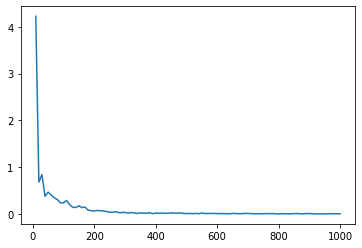

In [ ]:
eyesModel = trainEyesModel()
eyesForeheadModel = trainEyesForeheadModel()
noseModel = trainNoseModel()
eyesNoseModel = trainEyesNoseModel()
jawModel = trainJawModel()

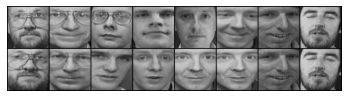

Epoch: 0 	 Loss: 2.0038180351257324
Epoch: 1 	 Loss: 0.6615078449249268
Epoch: 2 	 Loss: 0.451006680727005
Epoch: 3 	 Loss: 0.4132567346096039
Epoch: 4 	 Loss: 0.3967016935348511
Epoch: 5 	 Loss: 0.3158506453037262
Epoch: 6 	 Loss: 0.17487624287605286
Epoch: 7 	 Loss: 0.16493335366249084
Epoch: 8 	 Loss: 0.16369028389453888
Epoch: 9 	 Loss: 0.1577426940202713
Epoch: 10 	 Loss: 0.10981398075819016
Epoch: 11 	 Loss: 0.21315698325634003
Epoch: 12 	 Loss: 0.134528249502182
Epoch: 13 	 Loss: 0.11483839899301529
Epoch: 14 	 Loss: 0.10301706194877625
Epoch: 15 	 Loss: 0.09281771630048752
Epoch: 16 	 Loss: 0.06900814920663834
Epoch: 17 	 Loss: 0.058988865464925766
Epoch: 18 	 Loss: 0.07019306719303131
Epoch: 19 	 Loss: 0.049524519592523575
Epoch: 20 	 Loss: 0.07445596158504486
Epoch: 21 	 Loss: 0.04536537826061249
Epoch: 22 	 Loss: 0.08390254527330399
Epoch: 23 	 Loss: 0.05143173411488533
Epoch: 24 	 Loss: 0.029856009408831596
Epoch: 25 	 Loss: 0.047770656645298004
Epoch: 26 	 Loss: 0.02948760

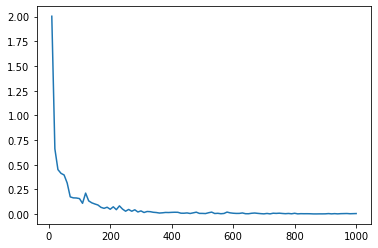

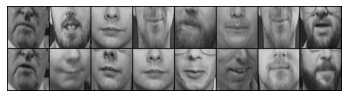

Epoch: 0 	 Loss: 2.1387829780578613
Epoch: 1 	 Loss: 0.660462498664856
Epoch: 2 	 Loss: 0.41899022459983826
Epoch: 3 	 Loss: 1.1057683229446411
Epoch: 4 	 Loss: 0.4520190358161926
Epoch: 5 	 Loss: 0.4086277484893799
Epoch: 6 	 Loss: 0.29575273394584656
Epoch: 7 	 Loss: 0.3381708264350891
Epoch: 8 	 Loss: 0.2998664677143097
Epoch: 9 	 Loss: 0.17147094011306763
Epoch: 10 	 Loss: 0.2097650021314621
Epoch: 11 	 Loss: 0.13580474257469177
Epoch: 12 	 Loss: 0.16524818539619446
Epoch: 13 	 Loss: 0.1441406011581421
Epoch: 14 	 Loss: 0.2477675974369049
Epoch: 15 	 Loss: 0.11237839609384537
Epoch: 16 	 Loss: 0.09213073551654816
Epoch: 17 	 Loss: 0.11566469818353653
Epoch: 18 	 Loss: 0.14383530616760254
Epoch: 19 	 Loss: 0.1206078976392746
Epoch: 20 	 Loss: 0.08413480222225189
Epoch: 21 	 Loss: 0.09755100309848785
Epoch: 22 	 Loss: 0.05399063974618912
Epoch: 23 	 Loss: 0.06246102973818779
Epoch: 24 	 Loss: 0.10453136265277863
Epoch: 25 	 Loss: 0.0769762322306633
Epoch: 26 	 Loss: 0.079523675143718

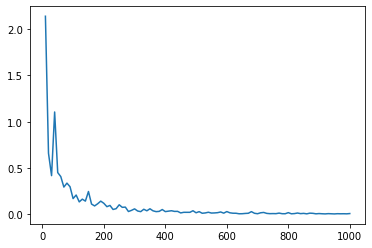

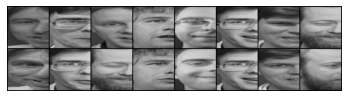

Epoch: 0 	 Loss: 1.1684201955795288
Epoch: 1 	 Loss: 0.7673897743225098
Epoch: 2 	 Loss: 0.5039803981781006
Epoch: 3 	 Loss: 0.552198588848114
Epoch: 4 	 Loss: 0.34673333168029785
Epoch: 5 	 Loss: 0.24867287278175354
Epoch: 6 	 Loss: 0.1957959681749344
Epoch: 7 	 Loss: 0.16257444024085999
Epoch: 8 	 Loss: 0.17069612443447113
Epoch: 9 	 Loss: 0.1834549903869629
Epoch: 10 	 Loss: 0.09521928429603577
Epoch: 11 	 Loss: 0.1477569341659546
Epoch: 12 	 Loss: 0.058267123997211456
Epoch: 13 	 Loss: 0.04966851696372032
Epoch: 14 	 Loss: 0.11572767049074173
Epoch: 15 	 Loss: 0.06669720262289047
Epoch: 16 	 Loss: 0.04396690055727959
Epoch: 17 	 Loss: 0.05825076252222061
Epoch: 18 	 Loss: 0.08060961961746216
Epoch: 19 	 Loss: 0.03277375176548958
Epoch: 20 	 Loss: 0.05013579502701759
Epoch: 21 	 Loss: 0.03240060806274414
Epoch: 22 	 Loss: 0.044692087918519974
Epoch: 23 	 Loss: 0.03257278352975845
Epoch: 24 	 Loss: 0.04195339232683182
Epoch: 25 	 Loss: 0.026916436851024628
Epoch: 26 	 Loss: 0.0302550

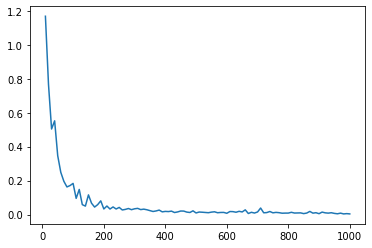

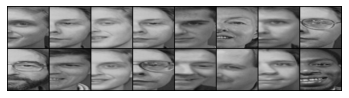

Epoch: 0 	 Loss: 1.11479651927948
Epoch: 1 	 Loss: 0.545417308807373
Epoch: 2 	 Loss: 0.5223498344421387
Epoch: 3 	 Loss: 0.3810546100139618
Epoch: 4 	 Loss: 0.48356401920318604
Epoch: 5 	 Loss: 0.3166433572769165
Epoch: 6 	 Loss: 0.20052160322666168
Epoch: 7 	 Loss: 0.10459350794553757
Epoch: 8 	 Loss: 0.1231948658823967
Epoch: 9 	 Loss: 0.12121813744306564
Epoch: 10 	 Loss: 0.13864807784557343
Epoch: 11 	 Loss: 0.07785650342702866
Epoch: 12 	 Loss: 0.15124216675758362
Epoch: 13 	 Loss: 0.13759270310401917
Epoch: 14 	 Loss: 0.14511670172214508
Epoch: 15 	 Loss: 0.09099522233009338
Epoch: 16 	 Loss: 0.09161902964115143
Epoch: 17 	 Loss: 0.09593293815851212
Epoch: 18 	 Loss: 0.07562420517206192
Epoch: 19 	 Loss: 0.07200396060943604
Epoch: 20 	 Loss: 0.04389214515686035
Epoch: 21 	 Loss: 0.043622542172670364
Epoch: 22 	 Loss: 0.06035517901182175
Epoch: 23 	 Loss: 0.03614133596420288
Epoch: 24 	 Loss: 0.02592654898762703
Epoch: 25 	 Loss: 0.02461814135313034
Epoch: 26 	 Loss: 0.0207628570

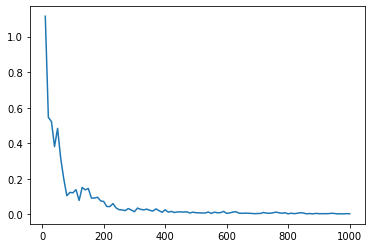

In [ ]:
#eyesModel = trainEyesModel()
#eyesForeheadModel = trainEyesForeheadModel()
#noseModel = trainNoseModel()
#eyesNoseModel = trainEyesNoseModel()
#jawModel = trainJawModel()
eyesToChinModel = trainEyesToChinModel()
noseToChinModel = trainNoseToChinModel()
leftHalfModel = trainLeftHalfModel()
rightHalfModel = trainRightHalfModel()

In [ ]:
FacemodelFile = "/content/drive/MyDrive/SupFiles/res10_300x300_ssd_iter_140000.caffemodel"
EyeRegionModelFile = "/content/drive/MyDrive/Detectors/cascade3.xml"
configFile = "/content/drive/MyDrive/SupFiles/deploy.prototxt.txt"

net = cv2.dnn.readNetFromCaffe(configFile, FacemodelFile)
eyePatchModel = cv2.CascadeClassifier(EyeRegionModelFile)

In [ ]:
def extractEyePatch(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  eyePatch = img[eyeY:eyeY+eyeH, eyeX:eyeX+eyeW]
  #plt.imshow(eyePatch, cmap='gray')
  #plt.show()
  
  return cv2.resize(eyePatch, (100, 100))

In [ ]:
def extractEyeAndForeheadPatch(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  EyeAndForeheadPatch = img[faceY:eyeY+eyeH, eyeX:eyeX+eyeW]
  #plt.imshow(EyeAndForeheadPatch, cmap='gray')
  #plt.show()
  
  return cv2.resize(EyeAndForeheadPatch, (100, 100))

In [ ]:
def extractEyeCheeksAndNosePatch(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH, noseBottom):
  patchECN =  img[eyeY:noseBottom, eyeX:eyeX+eyeW]
  #plt.imshow(patchECN, cmap='gray')
  #plt.show()
    
  return cv2.resize(patchECN, (100, 100))

In [ ]:
def extractNose(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  noseX = (int)(eyeX + eyeW/2) - 30
  noseY = (int)(eyeY + eyeH/2)
  noseH = 70
  noseW = 70
  nosePatch = img[noseY:noseY+noseH, noseX:noseX+noseW]
  #plt.imshow(nosePatch, cmap='gray')
  #plt.show()
  return cv2.resize(nosePatch, (100, 100)), (noseY+noseH)

In [ ]:
def extractMouth(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH, noseBottom):
  patchM =  img[noseBottom:faceH, eyeX:eyeX+eyeW]
  #plt.imshow(patchM, cmap='gray')
  #plt.show()
  return cv2.resize(patchM, (100, 100))

In [ ]:
def extractEyeToChin(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  eyeChinPatch = img[eyeY:faceH, eyeX:eyeX+eyeW]
  #plt.imshow(eyeChinPatch, cmap='gray')
  #plt.show()
  
  return cv2.resize(eyeChinPatch, (100, 100))

In [ ]:
def extractNoseToChin(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  noseChinPatch = img[eyeY+eyeH:faceH, eyeX:eyeX+eyeW]
  #plt.imshow(noseChinPatch, cmap='gray')
  #plt.show()
  
  return cv2.resize(noseChinPatch, (100, 100))

In [ ]:
def extractLeftHalf(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  leftHalfPatch = img[faceY:faceH, faceX:((int)(eyeX + (eyeW/2)))]
  #plt.imshow(leftHalfPatch, cmap='gray')
  #plt.show()
  
  return cv2.resize(leftHalfPatch, (100, 100))

In [ ]:
def extractRightHalf(img, faceX, faceY, faceW, faceH, eyeX, eyeY, eyeW, eyeH):
  rightHalfPatch = img[faceY:faceH, ((int)(eyeX + (eyeW/2))):faceW]
  #plt.imshow(rightHalfPatch, cmap='gray')
  #plt.show()
  
  return cv2.resize(rightHalfPatch, (100, 100))

In [ ]:
def getPatches(img):
  h, w = img.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,(300, 300), (104.0, 117.0, 123.0))
  net.setInput(blob)
  faces = net.forward()#to draw faces on image
  for i in range(faces.shape[2]):
    confidence = faces[0, 0, i, 2]
    if confidence > 0.5:
      box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
      (x, y, x1, y1) = box.astype("int") 
      if not( x1>300 or y1>300):
        #cv2.rectangle(img, (x, y), (x1, y1), (0, 0, 255), 2)
        eyePatches = eyePatchModel.detectMultiScale(img, 1.3, 5)
        countIndex = 0
        maxWidthIndex = 0
        maxWidth = 0
        for (xE, yE, wE, hE) in eyePatches:
          if wE > maxWidth:
            maxWidth = wE
            maxWidthIndex = countIndex
          countIndex = countIndex + 1
        #img = cv2.rectangle(img, (eyePatches[maxWidthIndex][0], eyePatches[maxWidthIndex][1]), (eyePatches[maxWidthIndex][0]+eyePatches[maxWidthIndex][2], eyePatches[maxWidthIndex][1]+eyePatches[maxWidthIndex][3]), (255,0,0), 2)
        #print(eyePatches[maxWidthIndex])
        xE= eyePatches[maxWidthIndex][0]
        yE= eyePatches[maxWidthIndex][1]
        wE= eyePatches[maxWidthIndex][2]
        hE= eyePatches[maxWidthIndex][3]

        

        eyePatch = extractEyePatch(img, x, y, x1, y1, xE, yE, wE, hE)
        eyeAndForeheadPatch = extractEyeAndForeheadPatch(img, x, y, x1, y1, xE, yE, wE, hE)
        nosePatch, noseBottom = extractNose(img, x, y, x1, y1, xE, yE, wE, hE)
        eyeCheeksAndNosePatch = extractEyeCheeksAndNosePatch(img, x, y, x1, y1, xE, yE, wE, hE, noseBottom)
        mouth = extractMouth(img, x, y, x1, y1, xE, yE, wE, hE, noseBottom)
        eyeToChinPatch = extractEyeToChin(img, x, y, x1, y1, xE, yE, wE, hE)
        noseToChinPatch = extractNoseToChin(img, x, y, x1, y1, xE, yE, wE, hE)
        leftHalfPatch = extractLeftHalf(img, x, y, x1, y1, xE, yE, wE, hE)
        rightHalfPatch = extractRightHalf(img, x, y, x1, y1, xE, yE, wE, hE)

        transTensor =  transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])
        

        #Converting patches to tensors
        eyePatch = Image.fromarray(np.uint8(eyePatch)).convert("L")
        eyePatch = transTensor(eyePatch)
        eyePatch = eyePatch[None, :, :, :]

        eyeAndForeheadPatch = Image.fromarray(np.uint8(eyeAndForeheadPatch)).convert("L")
        eyeAndForeheadPatch = transTensor(eyeAndForeheadPatch)
        eyeAndForeheadPatch = eyeAndForeheadPatch[None, :, :, :]

        nosePatch = Image.fromarray(np.uint8(nosePatch)).convert("L")
        nosePatch = transTensor(nosePatch)
        nosePatch = nosePatch[None, :, :, :]

        eyeCheeksAndNosePatch = Image.fromarray(np.uint8(eyeCheeksAndNosePatch)).convert("L")
        eyeCheeksAndNosePatch = transTensor(eyeCheeksAndNosePatch)
        eyeCheeksAndNosePatch = eyeCheeksAndNosePatch[None, :, :, :]

        mouth = Image.fromarray(np.uint8(mouth)).convert("L")
        mouth = transTensor(mouth)
        mouth = mouth[None, :, :, :]

        eyeToChinPatch = Image.fromarray(np.uint8(eyeToChinPatch)).convert("L")
        eyeToChinPatch = transTensor(eyeToChinPatch)
        eyeToChinPatch = eyeToChinPatch[None, :, :, :]

        noseToChinPatch = Image.fromarray(np.uint8(noseToChinPatch)).convert("L")
        noseToChinPatch = transTensor(noseToChinPatch)
        noseToChinPatch = noseToChinPatch[None, :, :, :]

        leftHalfPatch = Image.fromarray(np.uint8(leftHalfPatch)).convert("L")
        leftHalfPatch = transTensor(leftHalfPatch)
        leftHalfPatch = leftHalfPatch[None, :, :, :]

        rightHalfPatch = Image.fromarray(np.uint8(rightHalfPatch)).convert("L")
        rightHalfPatch = transTensor(rightHalfPatch)
        rightHalfPatch = rightHalfPatch[None, :, :, :]
        #eyeToChinPatch = extractEyeToChin(img, x, y, x1, y1, xE, yE, wE, hE)
        #noseToChinPatch = extractNoseToChin(img, x, y, x1, y1, xE, yE, wE, hE)
        #leftHalfPatch = extractLeftHalf(img, x, y, x1, y1, xE, yE, wE, hE)
        #rightHalfPatch = extractRightHalf(img, x, y, x1, y1, xE, yE, wE, hE)

        return eyePatch, eyeAndForeheadPatch, nosePatch, eyeCheeksAndNosePatch, mouth, eyeToChinPatch, noseToChinPatch, leftHalfPatch, rightHalfPatch


In [ ]:
import os
from itertools import combinations 

imageDirName = []
subDirectories = os.listdir(ConfigClass.test_dir)

for i, person in enumerate(subDirectories):
  imageNames = os.listdir(ConfigClass.test_dir+"/"+person)
  for imageName in imageNames:
    imageDirName.append((person, imageName))

#861 pairs
comb = combinations(imageDirName,2)
#transTensor =  transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

y = []
distancesEyes = []
distancesEyesAndForehead = []
distancesNose = []
distancesEyesCheeksAndNose = []
distancesMouth = []
distancesEyeToChin = []
distancesNoseToChin = []
distancesLeftHalf = []
distancesRightHalf = []

for pairTupples in list(comb):
  fullImage1 = cv2.imread(ConfigClass.test_dir+"/"+pairTupples[0][0]+"/"+pairTupples[0][1])
  fullImage1 = cv2.resize(fullImage1, (300, 300))
  fullImage2 = cv2.imread(ConfigClass.test_dir+pairTupples[1][0]+"/"+pairTupples[1][1])
  fullImage2 = cv2.resize(fullImage2, (300, 300))
  #Get patches
  eyesPatch1, eyeAndForeheadPatch1, nosePatch1, eyeCheeksAndNosePatch1, mouth1, eyeToChinPatch1, noseToChinPatch1, leftHalfPatch1, rightHalfPatch1  = getPatches(fullImage1)
  eyesPatch2, eyeAndForeheadPatch2, nosePatch2, eyeCheeksAndNosePatch2, mouth2, eyeToChinPatch2, noseToChinPatch2, leftHalfPatch2, rightHalfPatch2 = getPatches(fullImage2)
  
  label = 0
  if pairTupples[0][0] == pairTupples[1][0]:
    label = 1
  #print(label)
  y.append(label)

  outEyes1, outEyes2 = eyesModel(eyesPatch1.cuda(), eyesPatch2.cuda())
  distanceEyes = F.pairwise_distance(outEyes1, outEyes2)
  distancesEyes.append(distanceEyes.item())

  outEyesForehead1, outEyesForehead2 = eyesForeheadModel(eyeAndForeheadPatch1.cuda(), eyeAndForeheadPatch2.cuda())
  distanceEyesForehead = F.pairwise_distance(outEyesForehead1, outEyesForehead2)
  distancesEyesAndForehead.append(distanceEyesForehead.item())

  outNose1, outNose2 = noseModel(nosePatch1.cuda(), nosePatch2.cuda())
  distanceNose = F.pairwise_distance(outNose1, outNose2)
  distancesNose.append(distanceNose.item())

  outEyesCheeksNose1, outEyesCheeksNose2 = eyesNoseModel(eyeCheeksAndNosePatch1.cuda(), eyeCheeksAndNosePatch2.cuda())
  distanceEyesCheeksNose = F.pairwise_distance(outEyesCheeksNose1, outEyesCheeksNose2)
  distancesEyesCheeksAndNose.append(distanceEyesCheeksNose.item())

  outMouth1, outMouth2 = jawModel(mouth1.cuda(), mouth2.cuda())
  distanceMouth = F.pairwise_distance(outMouth1, outMouth2)
  distancesMouth.append(distanceMouth.item())

  outEyeToChin1, outEyeToChin2 = eyesToChinModel(eyeToChinPatch1.cuda(), eyeToChinPatch2.cuda())
  distanceEyeToChin = F.pairwise_distance(outEyeToChin1, outEyeToChin2)
  distancesEyeToChin.append(distanceEyeToChin.item())

  outNoseToChin1, outNoseToChin2 = noseToChinModel(noseToChinPatch1.cuda(), noseToChinPatch2.cuda())
  distanceNoseToChin = F.pairwise_distance(outNoseToChin1, outNoseToChin2)
  distancesNoseToChin.append(distanceNoseToChin.item())

  outLeftHalf1, outLeftHalf2 = leftHalfModel(leftHalfPatch1.cuda(), leftHalfPatch2.cuda())
  distanceLeftHalf = F.pairwise_distance(outLeftHalf1, outLeftHalf2)
  distancesLeftHalf.append(distanceLeftHalf.item())

  outRightHalf1, outRightHalf2 = rightHalfModel(rightHalfPatch1.cuda(), rightHalfPatch2.cuda())
  distanceRightHalf = F.pairwise_distance(outRightHalf1, outRightHalf2)
  distancesRightHalf.append(distanceRightHalf.item())


#Normalizing distances [0,1]
disNormalizedEyes = []
disNormalizedEyesForehead = []
disNormalizedEyesCheeksNose = []
disNormalizedNose = []
disNormalizedMouth = []
disNormalizedEyeToChin = []
disNormalizedNoseToChin = []
disNormalizedLeftHalf = []
disNormalizedRightHalf = []
for k in range(len(distancesMouth)):
  disNormalizedEyes.append((distancesEyes[k] - min(distancesEyes))/ (max(distancesEyes) - min(distancesEyes)))
  disNormalizedEyesForehead.append((distancesEyesAndForehead[k] - min(distancesEyesAndForehead))/ (max(distancesEyesAndForehead) - min(distancesEyesAndForehead)))
  disNormalizedNose.append((distancesNose[k] - min(distancesNose))/ (max(distancesNose) - min(distancesNose)))
  disNormalizedEyesCheeksNose.append((distancesEyesCheeksAndNose[k] - min(distancesEyesCheeksAndNose))/ (max(distancesEyesCheeksAndNose) - min(distancesEyesCheeksAndNose)))
  disNormalizedMouth.append((distancesMouth[k] - min(distancesMouth))/ (max(distancesMouth) - min(distancesMouth)))

  disNormalizedEyeToChin.append((distancesEyeToChin[k] - min(distancesEyeToChin))/ (max(distancesEyeToChin) - min(distancesEyeToChin)))
  disNormalizedNoseToChin.append((distancesNoseToChin[k] - min(distancesNoseToChin))/ (max(distancesNoseToChin) - min(distancesNoseToChin)))
  disNormalizedLeftHalf.append((distancesLeftHalf[k] - min(distancesLeftHalf))/ (max(distancesLeftHalf) - min(distancesLeftHalf)))
  disNormalizedRightHalf.append((distancesRightHalf[k] - min(distancesRightHalf))/ (max(distancesRightHalf) - min(distancesRightHalf)))



*   Combination 1: Matde of patches 1,2,3,4
*   Combination 2: Made of patches 4, 5, 6, 8
*   Combination 3: Made of all the patches.



In [ ]:
def vote(thresh, disNormalizedEye, disNormalizedEyesForehead, disNormalizedNose, disNormalizedEyesCheeksNose, disNormalizedMouth, disNormalizedEyeToChin, disNormalizedNoseToChin, disNormalizedLeftHalf, disNormalizedRightHalf):
  countG = 0
  #'''
  if disNormalizedEye < thresh:
    countG +=1
  if disNormalizedEyesForehead < thresh:
    countG +=1
  if disNormalizedNose < thresh:
    countG +=1
  if disNormalizedEyesCheeksNose < thresh:
    countG +=1
  if disNormalizedMouth < thresh:
    countG +=1
  #'''
  
  '''
  if disNormalizedEyeToChin < thresh:
    countG +=1

  if disNormalizedNoseToChin < thresh:
    countG +=1

  if disNormalizedLeftHalf < thresh:
    countG +=1

  if disNormalizedRightHalf < thresh:
    countG +=1

  '''
  
  '''
  if disNormalizedEyeToChin < thresh:
    countG +=1
  if disNormalizedLeftHalf < thresh:
    countG +=1
  if disNormalizedRightHalf < thresh:
    countG +=1
  if disNormalizedEyesCheeksNose < thresh:
    countG +=1
  if disNormalizedMouth < thresh:
    countG +=1
  '''

  if countG>=3:
    return True
  else:
    return False
   
  

In [ ]:
thresholds = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0]
#print(len(thresholds))
FACounts = []
FRCounts = []
TPCounts = []
TNCounts = []
accPerThresh = []
for thresh in thresholds:
  countFA = 0
  countFR = 0
  TPCount = 0
  TNCount=0
  yHat = []
  acc = 0
  for i, disN in enumerate(disNormalizedEyes):
    if vote(thresh, disNormalizedEyes[i], disNormalizedEyesForehead[i], disNormalizedNose[i], disNormalizedEyesCheeksNose[i], disNormalizedMouth[i],disNormalizedEyeToChin[i], disNormalizedNoseToChin[i], disNormalizedLeftHalf[i], disNormalizedRightHalf[i]):
      yHat.append(1)
      if y[i]==0:
        countFA +=1
      else:
        TPCount +=1
    else:
      yHat.append(0)
      if y[i]==1:
        countFR +=1
      else:
        TNCount+=1
  acc = accuracy_score(y, yHat)
  accPerThresh.append(acc * 100)
  #FACounts.append((countFA/len(disNormalized))*100)
  #FRCounts.append((countFR/len(disNormalized))*100)
  FACounts.append(countFA)
  FRCounts.append(countFR)
  TPCounts.append(TPCount)
  TNCounts.append(TNCount)
TPRate = []
FPRate = []
FNRate = []
for i in range(len(thresholds)):
  TPRate.append(TPCounts[i] / (TPCounts[i] + FRCounts[i]))
  FPRate.append(FACounts[i] / (FACounts[i] + TNCounts[i]))
  FNRate.append(1 - TPRate[i])
ThreshAtEER = 0
EER = 0
for i in range(len(thresholds)):
  thresh = thresholds[i]
  
  #print(round(FPRate[i],1), round(FNRate[i],1))
  if round(FPRate[i],1) == round(FNRate[i],1):
    ThreshAtEER = thresh
    EER = FPRate[i]
    break
print("EER:",EER)
print("Threshold at EER", ThreshAtEER)


EER: 0.050505050505050504
Threshold at EER 0.25


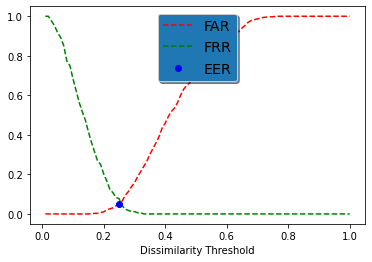

In [ ]:
fig, ax = plt.subplots()

ax.plot(thresholds, FPRate, 'r--', label='FAR')
ax.plot(thresholds, FNRate, 'g--', label='FRR')
plt.xlabel('Dissimilarity Threshold')
plt.plot(ThreshAtEER,EER,'bo', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
fileName1 = "AREERCom15Patches.png" 
plt.show()
#plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName1)

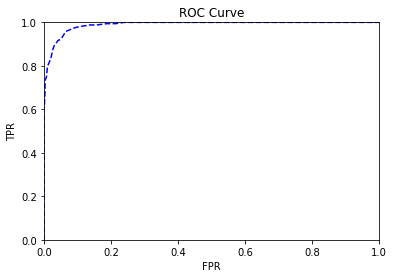

In [ ]:
#print(TPRate)
#print(FPRate)
plt.plot(FPRate,TPRate,'--b')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.axis([0, 1, 0, 1])

#plt.plot([0, 1], [0, 1], transform=ax.transAxes)
#plt.axline((1, 1), slope=-1)
plt.show()
fileName2 = "ROCCom15Patches.png" 
#plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

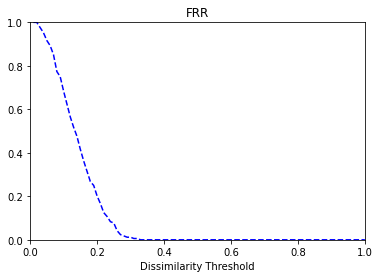

In [ ]:
TPRate = np.array(TPRate)
FNRate = np.array(FNRate)
plt.plot(thresholds,FNRate,'--b')
plt.xlabel('Dissimilarity Threshold')
plt.title('FRR')
plt.axis([0, 1, 0, 1])
plt.show()
fileName2 = "FRRCom21Patches.png" 
#plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

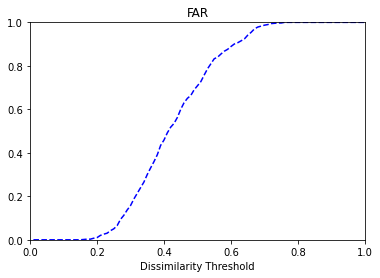

In [ ]:
FPRate = np.array(FPRate)
plt.plot(thresholds,FPRate,'--b')
plt.xlabel('Dissimilarity Threshold')
plt.title('FAR')
plt.axis([0, 1, 0, 1])
plt.show()
fileName2 = "FARCom15Patches.png" 
#plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

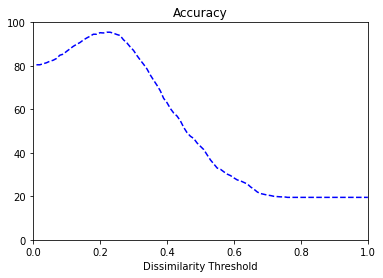

In [ ]:
accPerThresh = np.array(accPerThresh)
plt.plot(thresholds,accPerThresh,'--b')
plt.xlabel('Dissimilarity Threshold')
plt.title('Accuracy')
plt.axis([0, 1, 0, 100])
plt.show()
fileName2 = "ACCURACYCom15Patches.png" 
#plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)